In [20]:
import pandas as pd
from plotnine import *
import re

import sys
sys.path.insert(0, '../CODE/')
from visualization_utils import COLORS

# Hyperparameter tuning:
- Randomly chose 10% of the TFs for tuning and 90% for downstream cross validation
- The parameters being tuned:
   1. Learning rate
   2. Leaf paritioning regularizer
   3. Subsampling rate
- The max number of tuning iteration is set to 100
- The following results show the cross-TF validaiton on the 90% holdout TFs

# Yeast calling cards

In [10]:
tun_df = pd.read_csv('../OUTPUT/yeast_14tfs_cc_hp_tun_500trees/stats.csv.gz')
base_df = pd.read_csv('../OUTPUT/yeast_14tfs_cc_hp_base_500trees/stats.csv.gz')

tun_df['tuning'] = True
base_df['tuning'] = False

df = pd.concat([tun_df, base_df])

df2 = tun_df.merge(base_df, on=['cv', 'tf'])
df2['improv_frac'] = (df2['auprc_x'] - df2['auprc_y']) / df2['auprc_y']

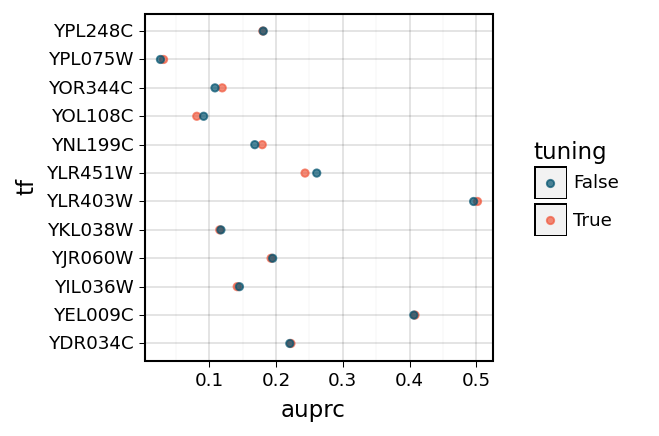

<ggplot: (-9223369075339746374)>

In [11]:
(
    ggplot(df, aes(x='auprc', y='tf', color='tuning'))
    + geom_point(alpha=.7)
    + scale_color_manual([COLORS['dark_blue'], COLORS['orange']])
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150)
)

Comparing the cross-TF valdiaiton with the tuned parameters vs the same TFs without (baseline), 2-3 TFs are improved and 2-3 are penalized.

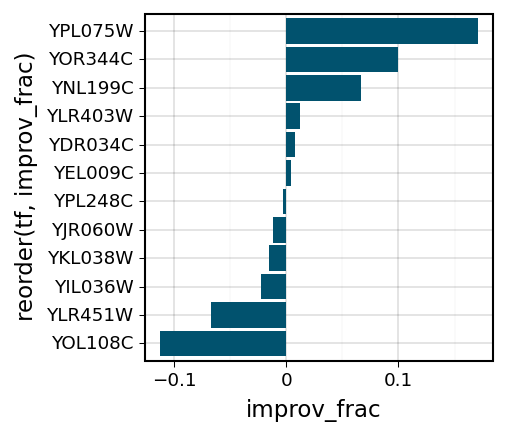

<ggplot: (2961515075592)>

In [13]:
(
    ggplot(df2, aes(x='reorder(tf, improv_frac)', y='improv_frac'))
    + geom_bar(stat='identity', fill=COLORS['dark_blue'])
    + coord_flip()
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150)
)

It is confirmed by looking at the fraction of improvement over the baseline AUPRC. The gain and lose are even.

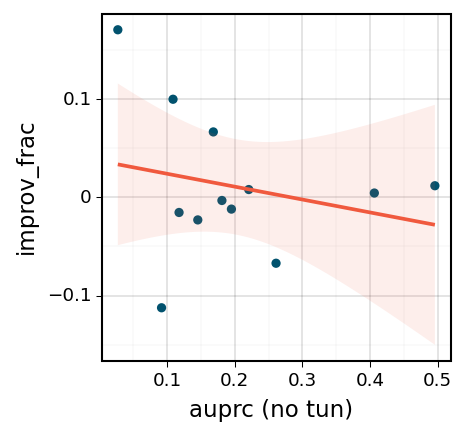

<ggplot: (2961515029347)>

In [14]:
(
    ggplot(df2, aes(x='auprc_y', y='improv_frac'))
    + geom_point(color=COLORS['dark_blue'])
    + geom_smooth(method='lm', color=COLORS['orange'], fill=COLORS['orange'], alpha=.1)
    + labs(x='auprc (no tun)')
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150)
)

The result of tuning does not strongly favor TFs with higher or lower baseline AUPRC.

# Yeast ChIP-exo

In [15]:
tun_df = pd.read_csv('../OUTPUT/yeast_19tfs_chipexo_hp_tun_500trees/stats.csv.gz')
base_df = pd.read_csv('../OUTPUT/yeast_19tfs_chipexo_hp_base_500trees/stats.csv.gz')

tun_df['tuning'] = True
base_df['tuning'] = False

df = pd.concat([tun_df, base_df])

df2 = tun_df.merge(base_df, on=['cv', 'tf'])
df2['improv_frac'] = (df2['auprc_x'] - df2['auprc_y']) / df2['auprc_y']

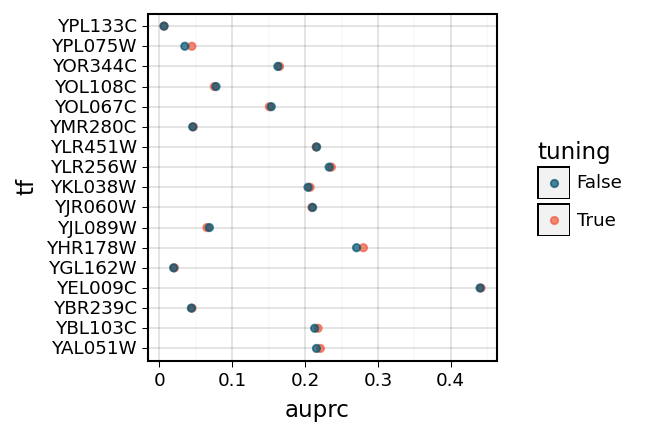

<ggplot: (2961515145238)>

In [16]:
(
    ggplot(df, aes(x='auprc', y='tf', color='tuning'))
    + geom_point(alpha=.7)
    + scale_color_manual([COLORS['dark_blue'], COLORS['orange']])
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150)
)

Comparing the tuned vs baseline, a number of TFs are improved and by a reasonable margin. And no TFs are penalized signficantly.

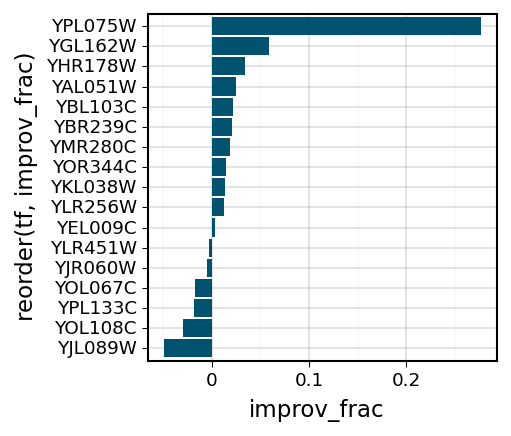

<ggplot: (-9223369075339555524)>

In [17]:
df2 = df2.sort_values('improv_frac')

(
    ggplot(df2, aes(x='reorder(tf, improv_frac)', y='improv_frac'))
    + geom_bar(stat='identity', fill=COLORS['dark_blue'])
    + coord_flip()
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150)
)

Fraction of improvement confirms it.

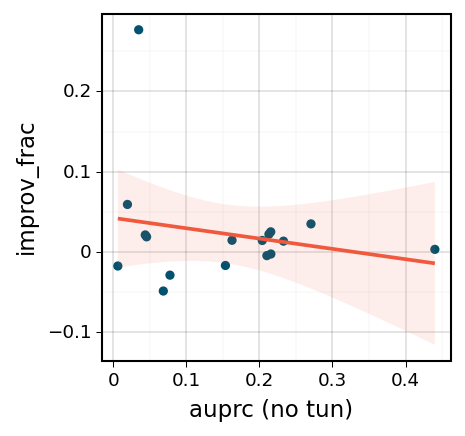

<ggplot: (2961513851389)>

In [18]:
(
    ggplot(df2, aes(x='auprc_y', y='improv_frac'))
    + geom_point(color=COLORS['dark_blue'])
    + geom_smooth(method='lm', color=COLORS['orange'], fill=COLORS['orange'], alpha=.1)
    + labs(x='auprc (no tun)')
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150)
)

No AUPRC bias observed.

# Human K562

In [31]:
tun_df = pd.DataFrame()

with open('../LOG/human_k562_hp_tun_32374555.out', 'r') as f:
    lines = f.readlines()
    
    for line in lines:
        if 'CV performance' in line:
            found = re.findall(r'TF (.+?) in (.+?) AUPRC=(.+?)\n', line)
            
            if len(found) > 0:
                tf, _, auc = found[0]
                tun_df = tun_df.append(pd.Series({
                    'tf': tf,
                    'auprc': float(auc)
                }), ignore_index=True)

tun_df['tuning'] = True

In [32]:
base_df = pd.DataFrame()

with open('../LOG/human_k562_hp_tun_32423964.out', 'r') as f:
    lines = f.readlines()
    
    for line in lines:
        if 'CV performance' in line:
            found = re.findall(r'TF (.+?) in (.+?) AUPRC=(.+?)\n', line)
            
            if len(found) > 0:
                tf, _, auc = found[0]
                base_df = base_df.append(pd.Series({
                    'tf': tf,
                    'auprc': float(auc)
                }), ignore_index=True)

base_df['tuning'] = False

In [33]:
df = pd.concat([tun_df, base_df])

df2 = tun_df.merge(base_df, on=['tf'])
df2['improv_frac'] = (df2['auprc_x'] - df2['auprc_y']) / df2['auprc_y']

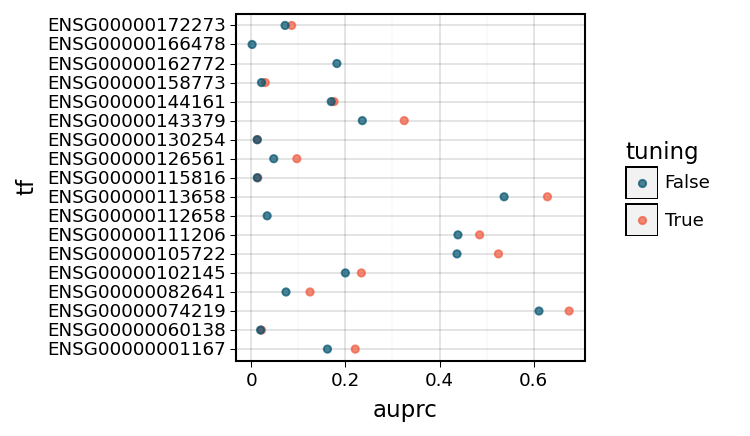

<ggplot: (2961513893426)>

In [34]:
(
    ggplot(df, aes(x='auprc', y='tf', color='tuning'))
    + geom_point(alpha=.7)
    + scale_color_manual([COLORS['dark_blue'], COLORS['orange']])
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150)
)

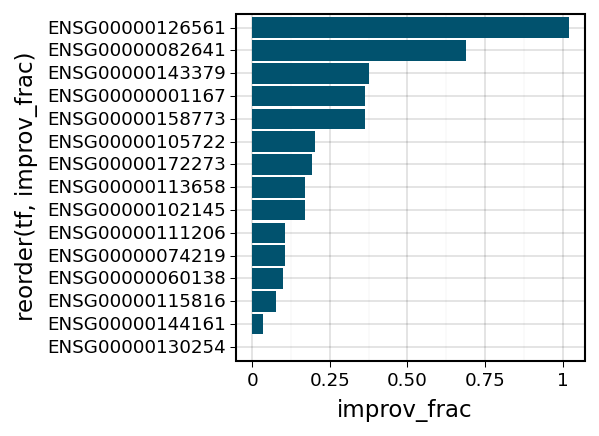

<ggplot: (2961513249989)>

In [35]:
df2 = df2.sort_values('improv_frac')

(
    ggplot(df2, aes(x='reorder(tf, improv_frac)', y='improv_frac'))
    + geom_bar(stat='identity', fill=COLORS['dark_blue'])
    + coord_flip()
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150)
)

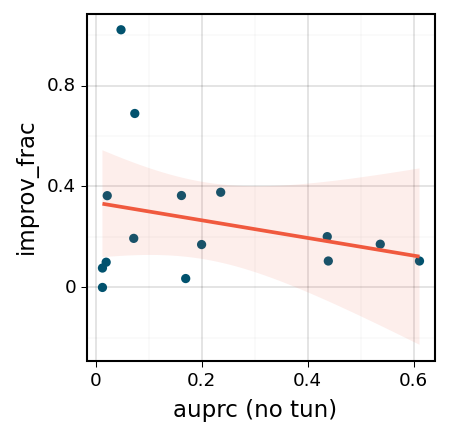

<ggplot: (2961515033036)>

In [36]:
(
    ggplot(df2, aes(x='auprc_y', y='improv_frac'))
    + geom_point(color=COLORS['dark_blue'])
    + geom_smooth(method='lm', color=COLORS['orange'], fill=COLORS['orange'], alpha=.1)
    + labs(x='auprc (no tun)')
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150)
)